In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 25
INIT_LR = .001
BS = 8
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/plants/Thesis_dataset'
width=256
height=256
depth=3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

                    
            for image in plant_disease_image_list[:85]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".png")==True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bel

In [5]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [6]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [7]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.25, random_state = 42) 

[INFO] Spliting data to train, test


In [8]:
x_train.shape

(2422, 256, 256, 3)

In [ ]:
x_test.shape

(808, 256, 256, 3)

In [ ]:
y_train.shape

(2422, 38)

In [8]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [9]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [11]:
import tensorflow as tf  
checkpoint_filepath='/content/drive/MyDrive/Plants/myxception.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [12]:
from keras.optimizers import adam_v2

In [13]:
optimizer = adam_v2.Adam(learning_rate = INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='categorical_crossentropy',  optimizer = optimizer  , metrics=['accuracy'])

# train the network
print("[INFO] training network...")

[INFO] training network...


In [14]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=55, verbose=1,
    callbacks=[model_checkpoint_callback]
    )
model.load_weights(checkpoint_filepath)

Epoch 1/55
302/302 [==============================] - 57s 153ms/step - loss: 3.9865 - accuracy: 0.1433 - val_loss: 4.6166 - val_accuracy: 0.1584
Epoch 2/55
302/302 [==============================] - 38s 125ms/step - loss: 3.4458 - accuracy: 0.2013 - val_loss: 9.6941 - val_accuracy: 0.0916
Epoch 3/55
302/302 [==============================] - 38s 125ms/step - loss: 3.5770 - accuracy: 0.1860 - val_loss: 11.9210 - val_accuracy: 0.0309
Epoch 4/55
302/302 [==============================] - 40s 133ms/step - loss: 3.3099 - accuracy: 0.2100 - val_loss: 3.4943 - val_accuracy: 0.2537
Epoch 5/55
302/302 [==============================] - 38s 127ms/step - loss: 2.7510 - accuracy: 0.2854 - val_loss: 10.3864 - val_accuracy: 0.0891
Epoch 6/55
302/302 [==============================] - 37s 123ms/step - loss: 2.5459 - accuracy: 0.3297 - val_loss: 7.0409 - val_accuracy: 0.1485
Epoch 7/55
302/302 [==============================] - 40s 131ms/step - loss: 2.4978 - accuracy: 0.3360 - val_loss: 1.7375 - val_

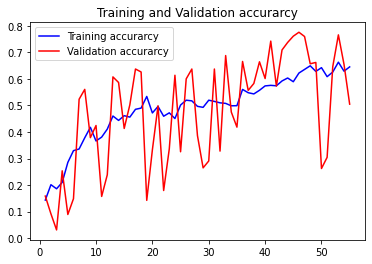

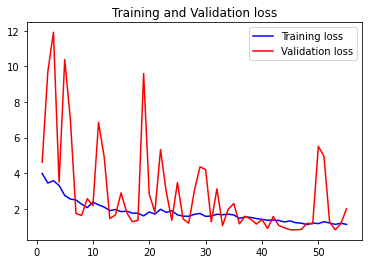

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print(label_binarizer.classes_)

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

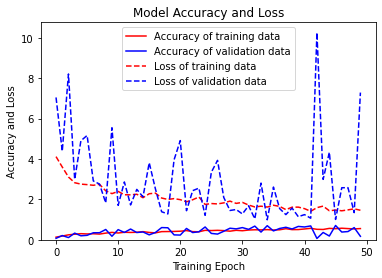

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


In [16]:
testpred = model.predict(x_test)

In [17]:
LABELS = ['Apple___Apple_scab' ,'Apple___Black_rot' ,'Apple___Cedar_apple_rust',
 'Apple___healthy', 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_' ,'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy' ,'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)' ,'Peach___Bacterial_spot',
 'Peach___healthy' ,'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy' ,'Potato___Early_blight' ,'Potato___Late_blight',
 'Potato___healthy' ,'Raspberry___healthy', 'Soybean___healthy',
 'Squash___Powdery_mildew' ,'Strawberry___Leaf_scorch',
 'Strawberry___healthy' ,'Tomato___Bacterial_spot', 'Tomato___Early_blight',
 'Tomato___Late_blight' ,'Tomato___Leaf_Mold' ,'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

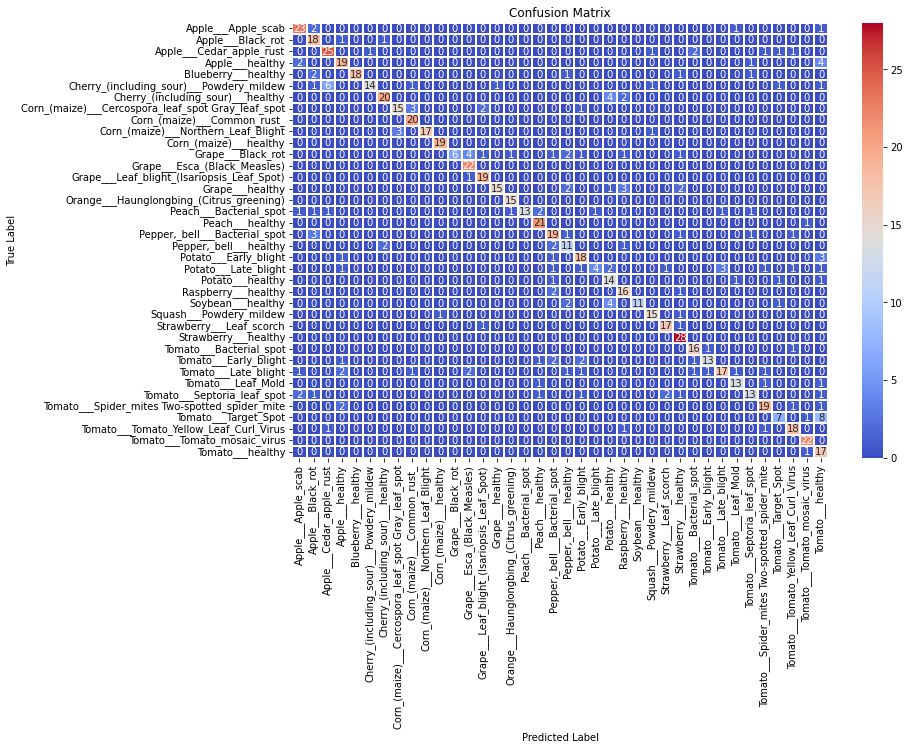

              precision    recall  f1-score   support

           0       0.79      0.85      0.82        27
           1       0.64      0.90      0.75        20
           2       0.76      0.78      0.77        32
           3       0.70      0.73      0.72        26
           4       1.00      0.78      0.88        23
           5       0.93      0.54      0.68        26
           6       0.87      0.77      0.82        26
           7       0.83      0.71      0.77        21
           8       0.80      1.00      0.89        20
           9       1.00      0.81      0.89        21
          10       0.95      1.00      0.97        19
          11       1.00      0.33      0.50        18
          12       0.76      1.00      0.86        22
          13       0.83      0.95      0.88        20
          14       0.94      0.65      0.77        23
          15       0.88      1.00      0.94        15
          16       1.00      0.59      0.74        22
          17       0.81    

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

#y_pred_test = model.predict(X_train)
# Take the class with the highest probability from the test predictions
#max_y_pred_test = np.argmax(y_pred_test, axis=1)
#max_y_test = np.argmax(y_train_hot, axis=1)

rounded_predictions = np.argmax(testpred, axis=1)
rounded_labels=np.argmax(y_test, axis=1)
show_confusion_matrix(rounded_labels, rounded_predictions)
print(classification_report(rounded_labels, rounded_predictions))

In [19]:
ypred = testpred.argmax(axis=-1)
ytest = y_test.argmax(axis=-1)

ROC AUC score: 0.8839659736902374


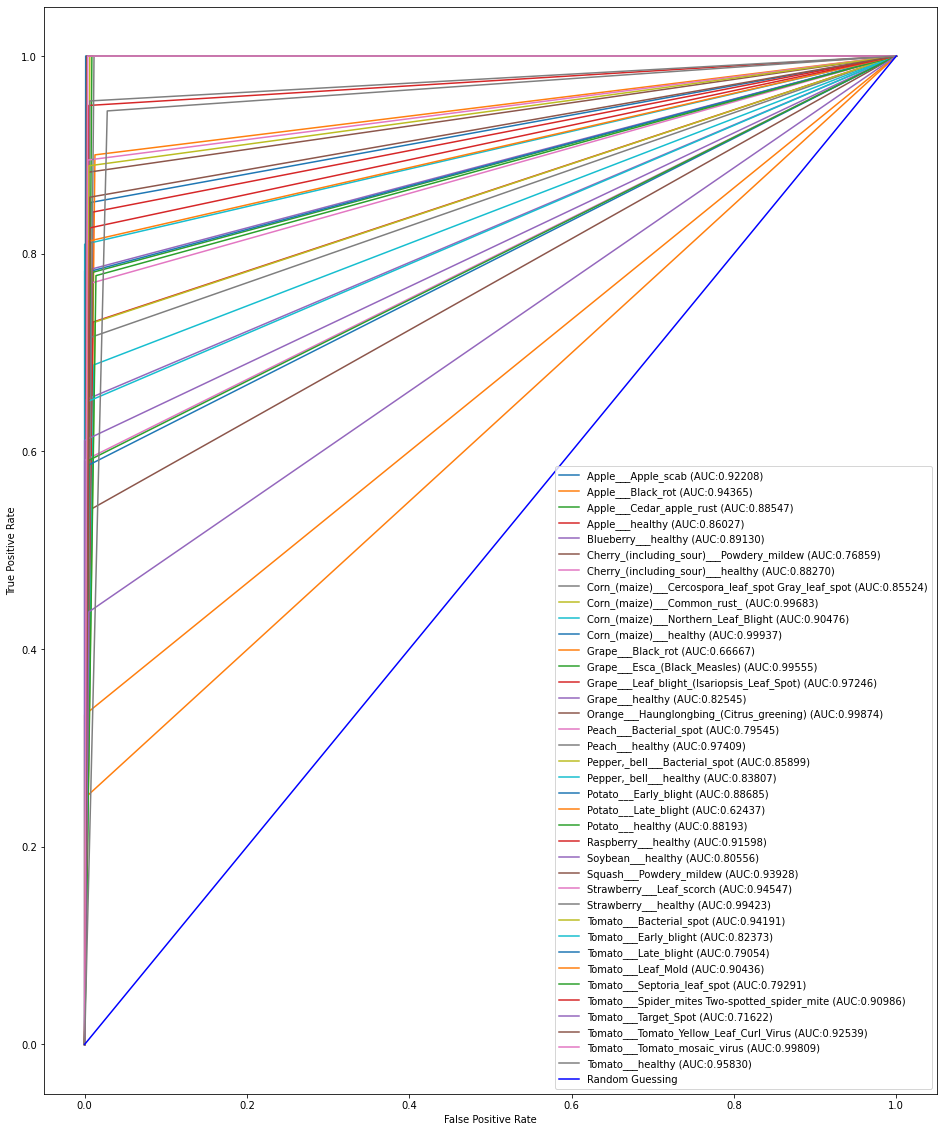

In [21]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['Apple___Apple_scab' ,'Apple___Black_rot' ,'Apple___Cedar_apple_rust',
 'Apple___healthy', 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_' ,'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy' ,'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)' ,'Peach___Bacterial_spot',
 'Peach___healthy' ,'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy' ,'Potato___Early_blight' ,'Potato___Late_blight',
 'Potato___healthy' ,'Raspberry___healthy', 'Soybean___healthy',
 'Squash___Powdery_mildew' ,'Strawberry___Leaf_scorch',
 'Strawberry___healthy' ,'Tomato___Bacterial_spot', 'Tomato___Early_blight',
 'Tomato___Late_blight' ,'Tomato___Leaf_Mold' ,'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (16, 20))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.5f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(ytest, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()